In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from scipy.sparse import csr_matrix
from fuzzywuzzy import process
from sklearn.neighbors import NearestNeighbors

In [2]:
movies_df = pd.read_csv('Data/movies.csv')
ratings_df = pd.read_csv('Data/ratings.csv')

### 1.1 - Movielens full - EDA

#### a)

In [3]:
display(movies_df, ratings_df)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy
58095,193880,Her Name Was Mumu (2016),Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi


,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
...,...,...,...,...
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524


In [4]:
display(
    movies_df.info(),
    ratings_df.info(),
    movies_df.describe().T,
    ratings_df.describe().T
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


None

None

,count,mean,std,min,25%,50%,75%,max
movieId,58098.0,111919.516197,59862.660956,1.0,72437.75,126549.0,161449.5,193886.0


,count,mean,std,min,25%,50%,75%,max
userId,27753444.0,1.419420e+05,8.170740e+04,1.0,71176.0,1.420220e+05,2.124590e+05,2.832280e+05
movieId,27753444.0,1.848800e+04,3.510263e+04,1.0,1097.0,2.716000e+03,7.150000e+03,1.938860e+05
rating,27753444.0,3.530445e+00,1.066353e+00,0.5,3.0,3.500000e+00,4.000000e+00,5.000000e+00
timestamp,27753444.0,1.193122e+09,2.160482e+08,789652004.0,998605251.0,1.174256e+09,1.422744e+09,1.537945e+09


###### Note: more plots coming at the end of the EDA

#### b)

##### Pretty expected tbh. Some great movies.

In [5]:
# Groupby movieId and get the size of each movie ratings list
ratings_per_movie = ratings_df.groupby('movieId').size()

ratings_per_movie = ratings_per_movie.sort_values(ascending=False)

top_10_ratings_movieId = ratings_per_movie.index[:10]

# Manually pull out single movies (in dataframes with one row format) in order maintain the correct order as
# there are no other indicators for sorting the list. I'm explicitly not using isin() because it returns a dataframe
# thats already sorted by index, thereby not allowing us to sort it outselves. I spent wayyy too long on this...
top_10_most_rated = [movies_df.loc[movies_df['movieId'] == i] for i in top_10_ratings_movieId]

# conCatenate all the individual dataframes into one. Meow!
top_10_most_rated = pd.concat(top_10_most_rated)

top_10_most_rated

,movieId,title,genres
315,318,"Shawshank Redemption, The (1994)",Crime|Drama
352,356,Forrest Gump (1994),Comedy|Drama|Romance|War
293,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
587,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
2487,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
523,527,Schindler's List (1993),Drama|War
108,110,Braveheart (1995),Action|Drama|War
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


#### c)

In [6]:
# Group by movieId and take the mean of the ratings per Id
avr_ratings = ratings_df.groupby('movieId')['rating'].mean()

# Use the top_10_ratings_movieId to get the avr ratings for the top 10 movies
top_10_most_rated['average rating'] = avr_ratings[top_10_ratings_movieId].values
top_10_most_rated

,movieId,title,genres,average rating
315,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.424188
352,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.056585
293,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.173971
587,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.151412
2487,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.149695
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.120455
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.665034
523,527,Schindler's List (1993),Drama|War,4.257502
108,110,Braveheart (1995),Action|Drama|War,4.008481
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.886649


#### d)

##### Looks to be following some sort of exponential curve. Technological advances seem to have made movie making more of a common practice.

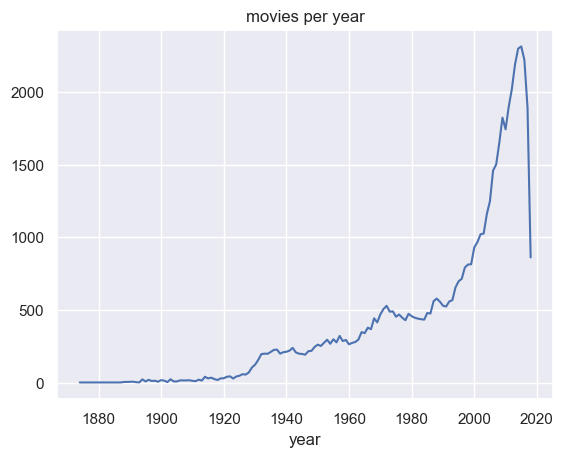

In [7]:
# extract the date in each movie title and create a new column for it
movies_df['year'] = movies_df['title'].str.extract("\((\d{4})\)", expand=False)

# Convert it to numeric so we can use mathematical operations
movies_df['year'] = pd.to_numeric(movies_df['year'])

# Get the movies per year
movies_per_year = movies_df.groupby('year').size()

ax = sns.lineplot(
    x=movies_per_year.index,
    y=movies_per_year.values
)

ax.set_title("movies per year");

##### Interesting. Initially thought the dip was due to Corona, but apparently not (although that certainly didnt help much either). What sorta doomsday event caused this? #MeToo?
###### Eh, probably just an anomaly in the data gathering process

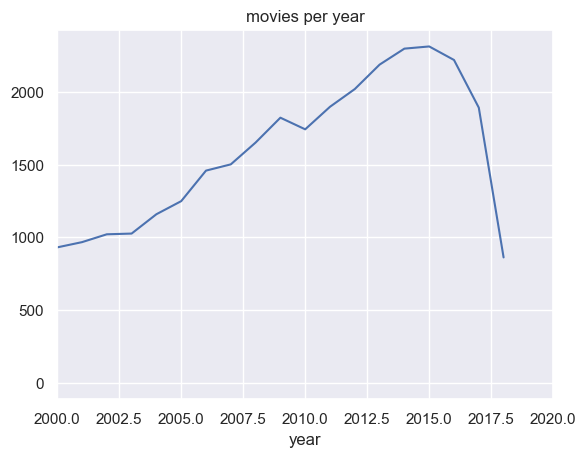

In [8]:
ax = sns.lineplot(
    x=movies_per_year.index,
    y=movies_per_year.values
)

ax.set_title("movies per year");
plt.xlim(2000, 2020)
plt.show()

#### e)

##### Again, more unexpected stuff. What could've possibly caused that gap? And how come the earlier movieId's have so many ratings?

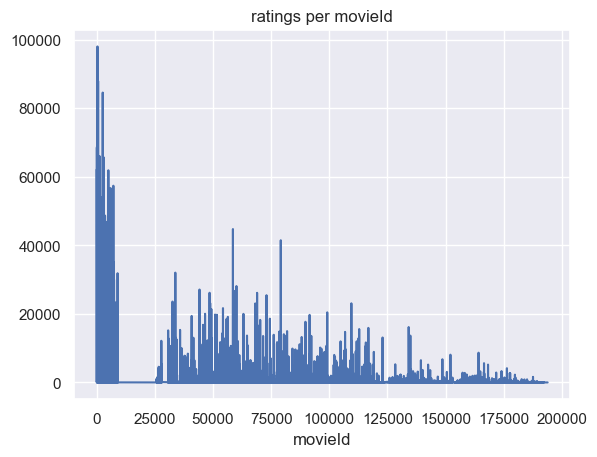

In [9]:
ax = sns.lineplot(
    x=ratings_per_movie.index,
    y=ratings_per_movie
);

ax.set_title("ratings per movieId");

### f)

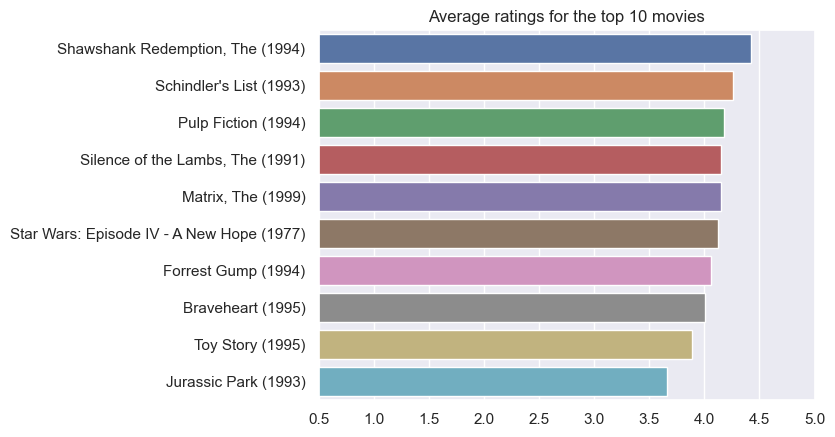

In [10]:
ax = sns.barplot(
    # sort by average rating, as that seems like a resonable thing to do
    data=top_10_most_rated.sort_values('average rating', ascending=False),
    y='title',
    x='average rating'
)

ax.set_title("Average ratings for the top 10 movies")

ax.set(xlabel=None)
ax.set(ylabel=None)

plt.xlim(0.5, 5);

#### Average ratings per decade

##### So it looks like the average ratings per decade didn't actually change much. I'd have personally believed that the ratings would be higher in the decades following up to the 2000's, given how many truly great movies where released back than.

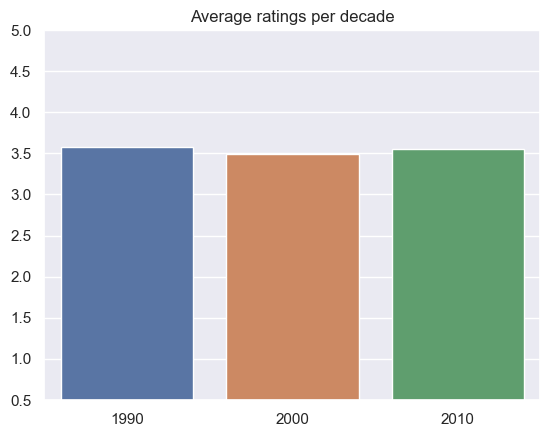

In [11]:
# NOTE: This plot assumes that the UNIX epoch time is representative of when the rating was actually added.
# I'm fairly sure it's correct, especially given i'm using post 1970's dates.

# convert timestamp from UNIX epoch time to normie time so we can use it more effectively.
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

# Round down the year to the nearest multiple of 10. example: 1995 -> 1990
ratings_df['decade'] = (ratings_df['timestamp'].dt.year // 10) * 10

# get decades from 1980 to 2010
ratings_1980_2010 = ratings_df[(ratings_df['decade'] >= 1980) & (ratings_df['decade'] < 2020)]

ratings_by_decade = ratings_1980_2010.groupby('decade')['rating'].mean()

ax = sns.barplot(
    y=ratings_by_decade,
    x=ratings_by_decade.index
)

ax.set_title("Average ratings per decade")

ax.set(xlabel=None)
ax.set(ylabel=None)

plt.ylim(0.5, 5);

In [12]:
# cleanup ratings_df after we've done all our plotting. timestamp and decade aren't needed from now on.
ratings_df = ratings_df.drop(['timestamp', 'decade'], axis=1)
ratings_df.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


### 1.2

##### Filtering the data

##### Drop ratings on movies without a date. Quite rare for movies to not have a date, and i dont think the user experience would get any worse if these ratings where dropped.

In [13]:
# Get all movieId's for movies with no year
movies_no_date = movies_df[movies_df['year'].isnull()]['movieId']

# Drop all ratings corresponding to those movieId's
ratings_df = ratings_df.drop(ratings_df[ratings_df['movieId'].isin(movies_no_date)].index)

print(f'new ratings_df length: {len(ratings_df)}')

new ratings_df length: 27746581


##### Drop ratings on movies without any genre specified. The reason for this is that essentially all worth while movies have at least one genre, so removing the ratings corresponding to movies which lack one sounds pretty sensible.

In [14]:
# Drop all movies with no genres listed
movies_no_genre = movies_df[movies_df['genres'] == '(no genres listed)']['movieId']
ratings_df = ratings_df.drop(ratings_df[ratings_df['movieId'].isin(movies_no_genre)].index)

print(f'new ratings_df length: {len(ratings_df)}')

new ratings_df length: 27730173


##### Drop ratings on movies older than the 1950's. You generally don't want such old movies to appear, i know i wouldn't.

In [15]:
# Get the movie id movies older than the 1950's
movies_ids = movies_df[movies_df['year'] < 1950]['movieId']

ratings_df = ratings_df.drop(ratings_df[ratings_df['movieId'].isin(movies_ids)].index)

print(f'new ratings_df length: {len(ratings_df)}')

new ratings_df length: 27127823


##### Drop ratings from users with <5 or >300 ratings as having that few/many ratings is either potentially unhelpful and or harmful to the predictions. Users with an especially high number of ratings could technically be bots, leading to significant biases.

In [16]:
num_ratings_user = ratings_df.groupby('userId').size()

# get the userId (e.g index) of users with <5 | >300 ratings
unsuitable_ratings_index = num_ratings_user[(num_ratings_user < 5) | (num_ratings_user > 300)].index

ratings_df = ratings_df.drop(ratings_df[ratings_df['userId'].isin(unsuitable_ratings_index)].index)

print(f'new ratings_df length: {len(ratings_df)}')

new ratings_df length: 13946104


##### Drop ratings lower than 3.5 to ensure only quality movies get recommended by only having the alg look at high ratings.

In [17]:
ratings_df = ratings_df.drop(ratings_df[ratings_df['rating'] < 3.5].index)
print(f'new ratings_df length: {len(ratings_df)}')

new ratings_df length: 9203281


##### Finally found the logical error!<br>In order to understand what was wrong, we first need to go understand how the system is intended to work.<br><br>So, the way the recommender system actually works, is that it, via the nearest neighbor algorithm, looks for what other users have rated and the similarities of those ratings to eachother in terms of the nearest neighbor distance. So lets say you search for the movie 'Toy Story', what the algorithm than does is look at users who rated that particular movie, and more specifically what other movies they happened to rate. By looking at correlation in user ratings across movies using dimensionality as an abstraction layer (e.g by looking at the distance), you can than pick up and recommend similar movies. In this case, the algorithm correctly suggested 'Toy Story 2', which is quite fair.<br><br>So whats the issue than?<br>Well, as it turns out, the only real issue causing the system to give wildly inaccurate results was as simple missmatch between the movie and rating id's. ... FIX

In [18]:
# NOTE: Partly taken from ChatGPT.

# Convert movieId & userId to Categorical's to make them work with csr_matrix
movieIds = pd.Categorical(ratings_df['movieId'], categories=movies_df['movieId'])
userIds = pd.Categorical(ratings_df['userId'])

# Create the csr matrix
ratings_movies_matrix = csr_matrix((ratings_df['rating'], (movieIds.codes, userIds.codes)))

ratings_movies_matrix.shape

(58092, 243558)

### 1.3

In [19]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)

In [20]:
# Fit model to the data
knn_model.fit(ratings_movies_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [21]:
def recommender(movie_name, data,model, n_recommendations ):
    model.fit(data)
    idx=process.extractOne(movie_name, movies_df['title'])[2]
    print('Movie Selected: ',movies_df['title'][idx], 'Index: ',idx)
    print('Searching for recommendations.....')
    distances, indices=model.kneighbors(data[idx], n_neighbors=n_recommendations)
    for i in indices:
        print(movies_df['title'][i].where(i!=idx))
    
recommender('Toy Story', mat_movies_users, knn_model,20)


Movie Selected:  Toy Story (1995) Index:  0
Searching for recommendations.....
0                                                     NaN
3028                                   Toy Story 2 (1999)
257             Star Wars: Episode IV - A New Hope (1977)
352                                   Forrest Gump (1994)
1242                            Back to the Future (1985)
360                                 Lion King, The (1994)
582                                        Aladdin (1992)
476                                  Jurassic Park (1993)
1184    Star Wars: Episode VI - Return of the Jedi (1983)
4791                                Monsters, Inc. (2001)
315                      Shawshank Redemption, The (1994)
6272                                  Finding Nemo (2003)
767                  Independence Day (a.k.a. ID4) (1996)
1171    Star Wars: Episode V - The Empire Strikes Back...
4212                                         Shrek (2001)
293                                   Pulp Fiction 